In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
dataset = image_dataset_from_directory('images')
class_names = dataset.class_names

Found 898 files belonging to 2 classes.


In [3]:
dataset.shuffle(buffer_size=32)
test_size = int(len(dataset) * 0.2)
test = dataset.take(test_size)
train = dataset.skip(test_size)

In [4]:
def display_dataset(dataset, sample_size):
	plt.figure(figsize=(5, 5))
	for images, labels in dataset.take(sample_size):
		for i in range(len(class_names)):
			plt.subplot(3, 4, int(labels[i])+1)
			plt.imshow(images[i].numpy().astype("uint8"))
			plt.title(class_names[labels[i]])
			plt.axis("off")
	plt.show()

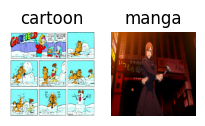

In [5]:
display_dataset(train, 20)

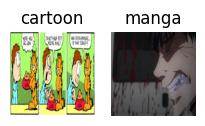

In [6]:
resizer = Sequential([Resizing(224, 224)])
display_dataset(train.map(lambda x, y: (resizer(x), y)), 20)

In [7]:
model = Sequential([
	Resizing(224, 224),
	ResNet50(weights='imagenet', include_top=False, pooling='max', classes=len(class_names))
])

In [8]:
def extract_images_and_labels(dataset):
	# images, labels = zip(*dataset)
	images, labels = [], []
	for i, l in dataset:
		images.append(i)
		labels.append(l)
	images = np.concatenate(images, axis=0)
	labels = np.concatenate(labels, axis=0)
	return images, labels

In [9]:
train_images, train_labels = extract_images_and_labels(train)
X_train = model.predict(train_images)
svc = SVC()
svc.fit(X_train, train_labels)

24/24 [==============================] - 72s 3s/step


SVC()

In [10]:
test_images, test_labels = extract_images_and_labels(test)
test_features = model.predict(test_images)
y_pred = svc.predict(test_features)

5/5 [==============================] - 13s 3s/step


Accuracy: 1.0%


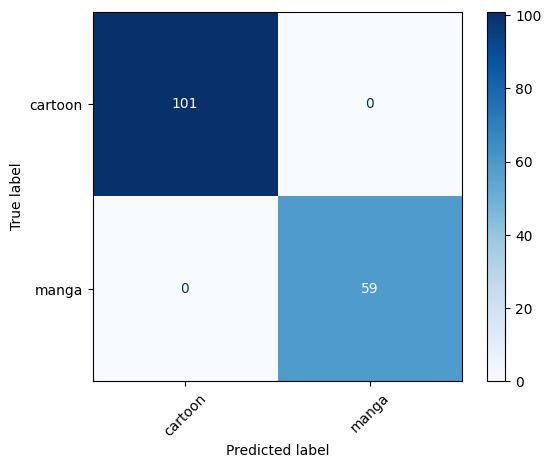

In [11]:
print(f'Accuracy: {accuracy_score(y_pred=y_pred, y_true=test_labels)}%')
ConfusionMatrixDisplay(
	confusion_matrix(y_pred=y_pred, y_true=test_labels),
	display_labels=class_names,
).plot(cmap='Blues')
plt.xticks(rotation=45)
plt.show()

In [12]:
diff_idx = []
same_idx = []

for i in range(len(y_pred)):
	if y_pred[i] != test_labels[i]:
		diff_idx.append(i)
	else:
		same_idx.append(i)

In [13]:
def plot_for_dataset(title: str, idx: list, nrows: int, ncols: int):
	if len(idx) == 0:
		print('No incorrectly labelled images')
		return
	fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
	fig.suptitle(title)
	for r in range(nrows):
		for c in range(ncols):
			i = idx[(r * ncols) + c]
			ax = axes[r, c]
			ax.set_title(f'Predicted: {class_names[y_pred[i]]}\nLabel: {class_names[test_labels[i]]}')
			ax.imshow(test_images[i].astype(np.uint8))
	plt.tight_layout()
	plt.show()

In [14]:
plot_for_dataset("Mislabelled images", diff_idx, 3, 3)

No incorrectly labelled images


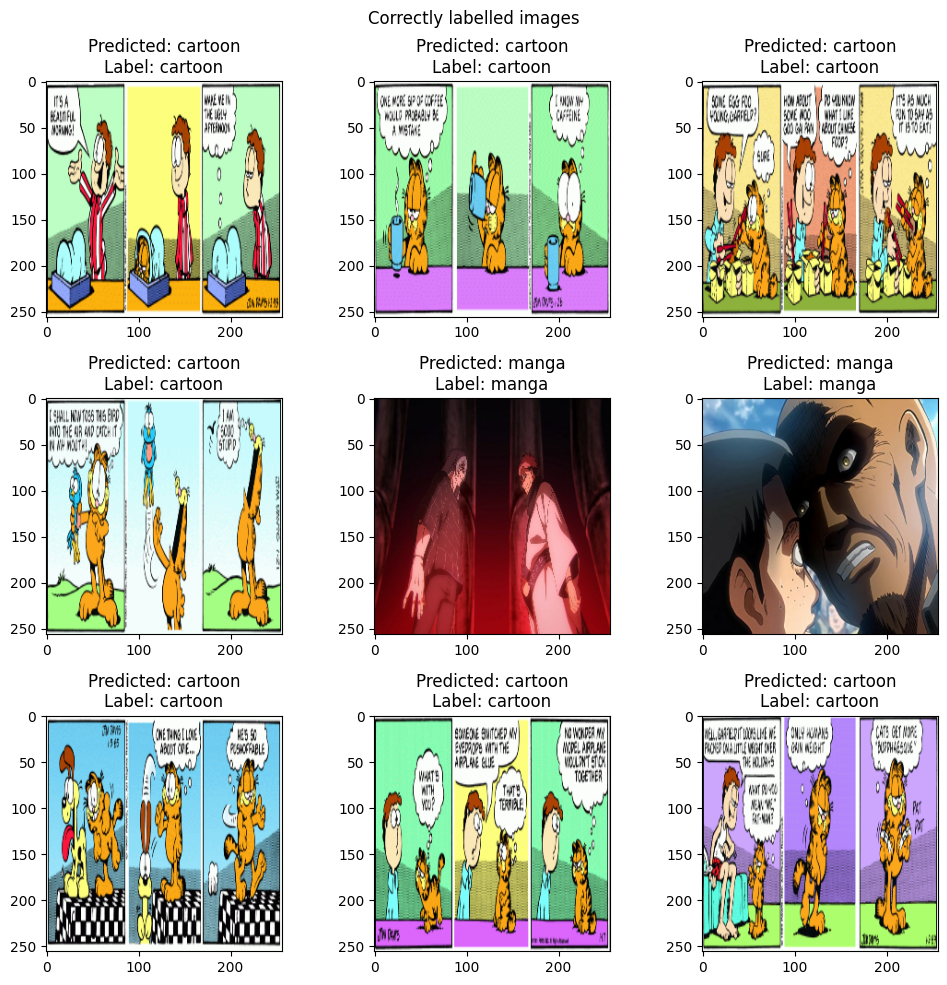

In [15]:
plot_for_dataset("Correctly labelled images", same_idx, 3, 3)

In [16]:
from PIL import Image

def classify_image(img: Image):
	return svc.predict(model.predict(np.array([img])))

def classify_image_from_path(path: str):
	return class_names[classify_image(Image.open(path))[0]]

for p in ['aot.jpeg', 'c-h.jpeg', 'op.webp', 'op1.jpeg']:
	print(p, classify_image_from_path(p))

1/1 [==============================] - 1s 955ms/step
aot.jpeg manga
1/1 [==============================] - 1s 663ms/step
c-h.jpeg cartoon
1/1 [==============================] - 0s 73ms/step
op.webp manga
1/1 [==============================] - 0s 73ms/step
op1.jpeg manga


In [17]:
import pickle
pickle.dump(model, open('image_to_features_model.pkl', 'wb'))
pickle.dump(svc, open('features_to_classes.pkl', 'wb'))

In [27]:
import joblib
joblib.dump(model, 'image_to_features_model.joblib')
joblib.dump(svc, 'features_to_classes.joblib')
# joblib.dump(classify_image_from_path, 'classifier.joblib')

['features_to_classes.joblib']

In [28]:
def classify_image(img: Image):
    label = svc.predict(model.predict(np.array([img])))[0]
    return class_names[label]

In [29]:
classify_image(Image.open('/Users/rajatjacob/Downloads/bukonohero/colored/0.png'))

ValueError: Found array with dim 4. SVC expected <= 2.

In [34]:
import streamlit as st
from PIL import Image
import joblib
import numpy as np

svc = joblib.load('image_to_features_model.joblib')
model = joblib.load('features_to_classes.joblib')
class_names = ['Cartoon', 'Manga']

print("Loaded models", svc, model)


def classify_image(img: Image):
    label = svc.predict(model.predict(np.array([img])))[0]
    return class_names[label]

Loaded models SVC() <keras.src.engine.sequential.Sequential object at 0x177c93550>


In [35]:
classify_image(Image.open('/Users/rajatjacob/Downloads/bukonohero/colored/0.png'))

1/1 [==============================] - 1s 671ms/step


'Cartoon'

In [18]:
# import os

# buko = {}

# root = '/Users/rajatjacob/Downloads/bukonohero/colored'
# for filename in os.listdir(root):
# 	try:
# 		path = os.path.join(root, filename)
# 		pred = classify_image_from_path(path)
# 		buko[pred] = buko.get(pred, 0)+1
# 	except:
# 		pass

# buko